In [4]:
import os, sys
import time
import datetime
import pandas as pd
import numpy as np
import math
from math import radians, cos, sin, asin, sqrt 
import random
import copy


import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.patches import Ellipse, Circle

ROOTDIR = os.path.abspath(os.path.realpath('./')) + '/Py'

sys.path.append(os.path.join(ROOTDIR, ''))

import dgckernel

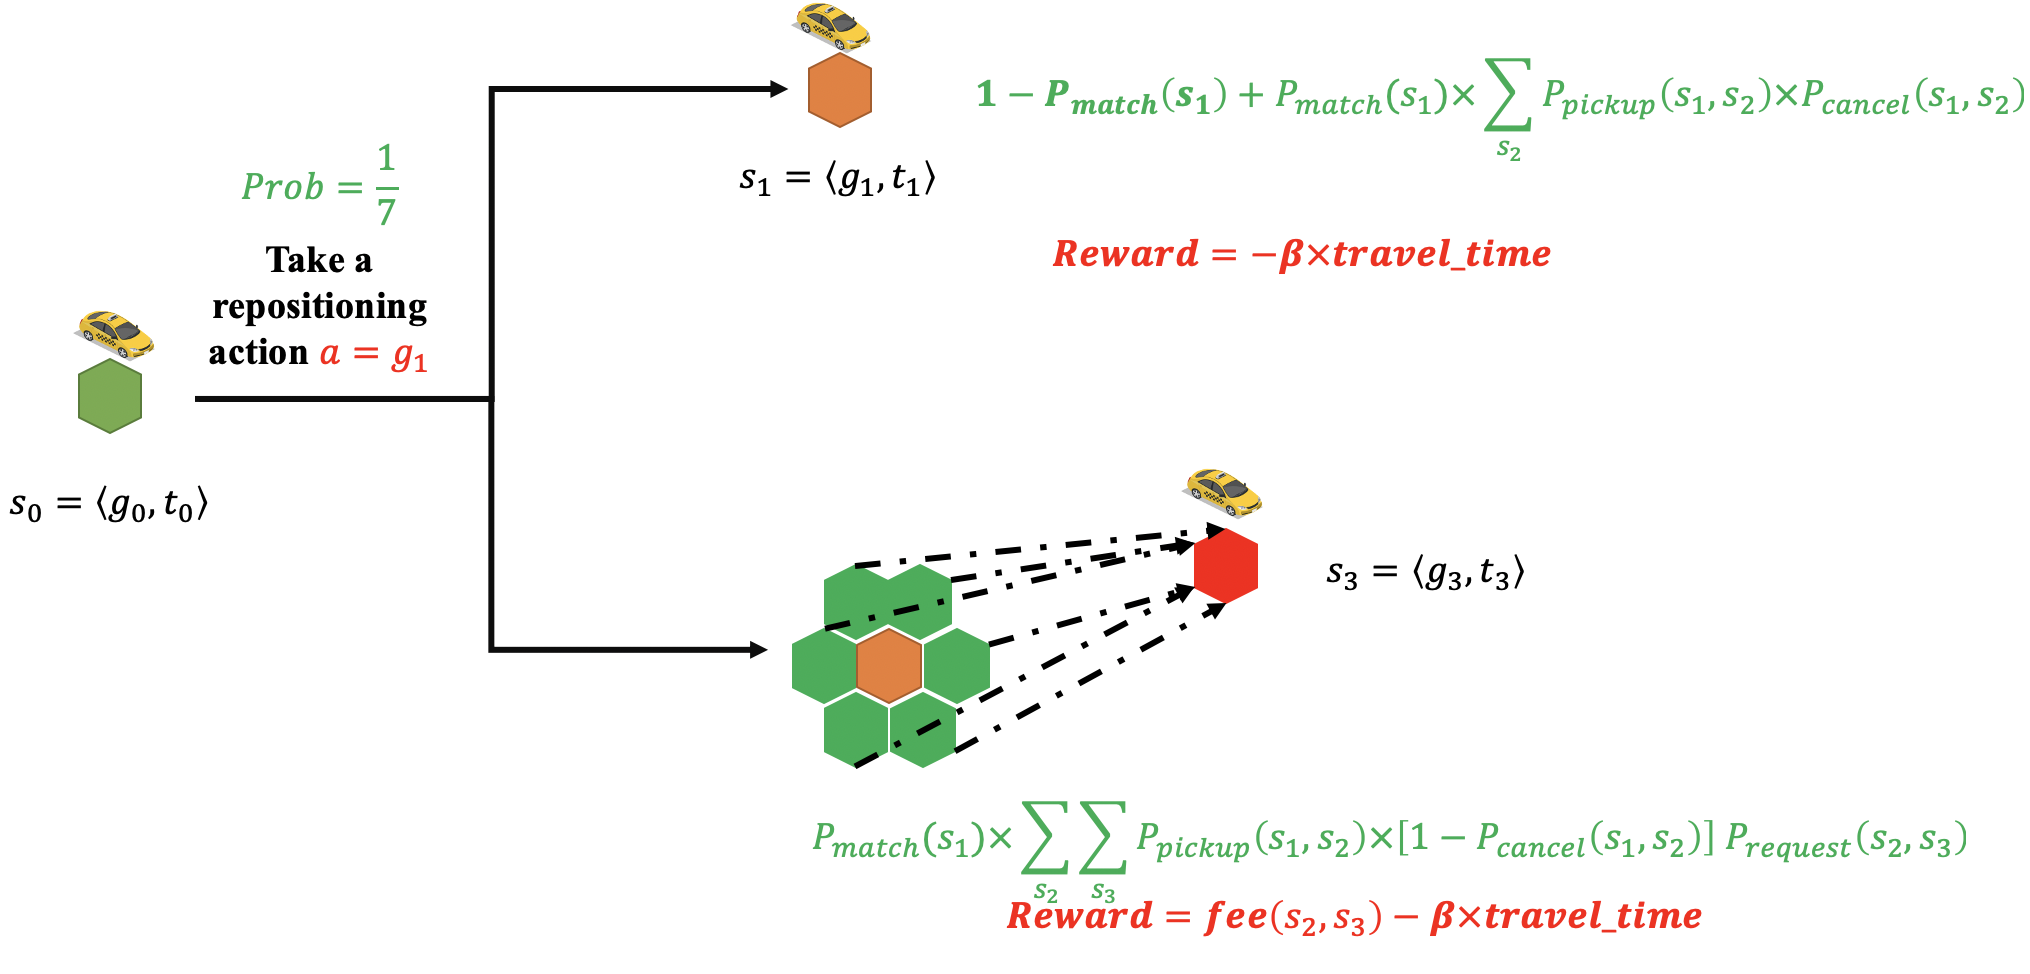

In [37]:
class Stamp_transition(object):
    
    def __init__(self, **kwargs):
        """ Load your trained model and initialize the parameters """
        pass
    
    def Get_date(self,stamp):
        dateArray = datetime.datetime.fromtimestamp(stamp)
        otherStyleTime = dateArray.strftime("%Y-%m-%d %H:%M:%S")
        return otherStyleTime[:10]
    
    '''Time stamp'''
    def Get_stamp(self,time_str):
        timeArray = time.strptime(time_str, "%Y-%m-%d %H:%M:%S")
        timeStamp = int(time.mktime(timeArray))
        return timeStamp
    
    '''Time step'''
    def Get_step(self,stamp,date_str,step):
        baseline = date_str+" 00:00:00";
        baseline = int(self.Get_stamp(baseline))
        current_step=int((stamp-baseline)/step)
        return current_step
    
    def Get_datelist(self, beginDate, endDate):
        date_list=[datetime.datetime.strftime(x,'%Y-%m-%d') for x in list(pd.date_range(start=beginDate, end=endDate))]
        return date_list
    
    def Get_weekday(self,date_str):
        date_str = date_str+" 00:00:00";
        date_str = time.strptime(date_str, "%Y-%m-%d %H:%M:%S")
        return date_str.tm_wday+1

    def Get_normalization(self,end_step,t_step):
        if t_step>=end_step:
            return t_step-end_step
        else:
            return t_step


class Spatial_calculation(object):
    
    def __init__(self, Zoom):
        """ Load your trained model and initialize the parameters """
        self.Zoom=Zoom
        self.CALCULATOR = dgckernel.Calculator()
        self.CALCULATOR.SetLayer(Zoom)
        
    '''GRID ID'''

    def get_grid(self,lng,lat):

        return self.CALCULATOR.HexCellKey(dgckernel.GeoCoord(lat, lng))

    '''GRID SHAPE'''

    def get_grid_shape(self,grid):

        return self.CALCULATOR.HexCellVertexesAndCenter(grid)
        
    '''Neighbor Grid'''

    def grid_neighbor(self, grid, low_layer, up_layer):

        neighbors = self.CALCULATOR.HexCellNeighbor(grid, up_layer)
        _neighbors = self.CALCULATOR.HexCellNeighbor(grid, low_layer)
        neighbors = [e for e in neighbors if e not in _neighbors]
        return neighbors 
    
    def grid_eliminate(self,grid_list,sw,ne):
        grid_result=list()
        for grid in grid_list:
            v_f,c_f=self.get_grid_shape(grid)
            c_lng,c_lat=c_f.lng,c_f.lat;
            if c_lng>=sw[1] and c_lng<=ne[1] and c_lat>=sw[0] and c_lat<=ne[0]:
                grid_result.append(grid)
        return grid_result
    
    def Geo_distance(self,lng1,lat1,lng2,lat2):
        lng1, lat1, lng2, lat2 = map(radians, [float(lng1), float(lat1), float(lng2), float(lat2)]) 
        dlon=lng2-lng1
        dlat=lat2-lat1
        a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2 
        distance=2*asin(sqrt(a))*6371 
        distance=round(distance,2)
        return distance
    
    '''Get Distance'''
    def get_grid_dis(self,f_grid,t_grid):

        f_shape,f_center=self.get_grid_shape(f_grid);
        t_shape,t_center=self.get_grid_shape(t_grid);

        Topology_dis=1.3*self.Geo_distance(f_center.lng,f_center.lat,t_center.lng,t_center.lat)

        return Topology_dis

# 0 Data initializing

In [38]:
'''Time range'''
end_step=144

spatial_calculation=Spatial_calculation(13)

stamp_transition=Stamp_transition()


'''Grid_range'''

Grid_range=pd.read_csv('./Results/Grid_info.csv')

Grid_range=Grid_range.drop(columns=['Unnamed: 0'])

Grid_range=Grid_range[['grid','Grid_id']]



'''Overall range'''
# southwest=[30.331759, 103.512892]
# northeast=[30.944065, 104.640393]

'''Sample range'''

southwest=[30.617149, 104.014056]
northeast=[30.698437, 104.128742]


lng,lat=104.066218,30.656725
sample_grid=spatial_calculation.get_grid(lng,lat)
All_grid = spatial_calculation.grid_neighbor(sample_grid, 0, 20)
All_grid.append(sample_grid)
All_grid=spatial_calculation.grid_eliminate(All_grid,southwest,northeast)
Grid_range=pd.DataFrame(All_grid,columns=['grid'])



In [20]:
'''Real Data Extracting'''

'''Request data'''

date_str='2016-11-01'

Request_data=pd.read_csv('Dataset/order_20161101.csv',header=None,\
                            names = ['Order_ID','Start_time','Stop_time','Pickup_Longitude','Pickup_Latitude',\
                                    'Dropoff_Longitude','Dropoff_Latitude','Reward_unit'])

Request_data['Pickup_Gird']=Request_data.apply(lambda x:spatial_calculation.get_grid(x['Pickup_Longitude'],x['Pickup_Latitude']),axis=1)

Request_data['Dropoff_Gird']=Request_data.apply(lambda x:spatial_calculation.get_grid(x['Dropoff_Longitude'],x['Dropoff_Latitude']),axis=1)

Request_data['Pickup_step']=Request_data.apply(lambda x:stamp_transition.Get_step(x['Start_time'],date_str,600), axis=1)

Request_data['Dropoff_step']=Request_data.apply(lambda x:stamp_transition.Get_step(x['Stop_time'],date_str,600), axis=1)

Request_data=Request_data[['Order_ID','Pickup_Gird','Dropoff_Gird','Pickup_step','Dropoff_step','Reward_unit']]

Request_data=Request_data.loc[Request_data['Pickup_step']<end_step]

'''Trajectory data'''


Tracectory_data=pd.read_csv('./Experiments/Demo/gps20161101.csv')

Tracectory_data=Tracectory_data.drop(columns=['Unnamed: 0'])

Tracectory_data.columns = ['Driver_ID','Order_ID','Dispatch_step','lng','lng','Dispatch_Grid']

Tracectory_data=Tracectory_data[['Driver_ID','Order_ID','Dispatch_Grid','Dispatch_step']].merge(Request_data[['Order_ID','Pickup_Gird']],on='Order_ID')

Tracectory_data=Tracectory_data.loc[Tracectory_data['Dispatch_step']<end_step]


'''Data filtering'''

'''Request_data'''

Request_data=Request_data.merge(Grid_range,left_on='Pickup_Gird',right_on='grid')

Request_data=Request_data[['Order_ID','Pickup_Gird','Dropoff_Gird','Pickup_step','Dropoff_step','Reward_unit']]

Request_data=Request_data.merge(Grid_range,left_on='Dropoff_Gird',right_on='grid')

Request_data=Request_data[['Order_ID','Pickup_Gird','Dropoff_Gird','Pickup_step','Dropoff_step','Reward_unit']]

'''Tracectory_data'''

Tracectory_data=Tracectory_data.drop_duplicates(subset=['Driver_ID','Order_ID'], keep='first')

Tracectory_data=Tracectory_data.merge(Grid_range,left_on='Dispatch_Grid',right_on='grid')

Tracectory_data=Tracectory_data[['Driver_ID','Order_ID','Dispatch_Grid','Dispatch_step','Pickup_Gird']]

Tracectory_data=Tracectory_data.merge(Grid_range,left_on='Pickup_Gird',right_on='grid')

Tracectory_data=Tracectory_data[['Driver_ID','Order_ID','Dispatch_Grid','Dispatch_step','Pickup_Gird']]


# 01 Modeling

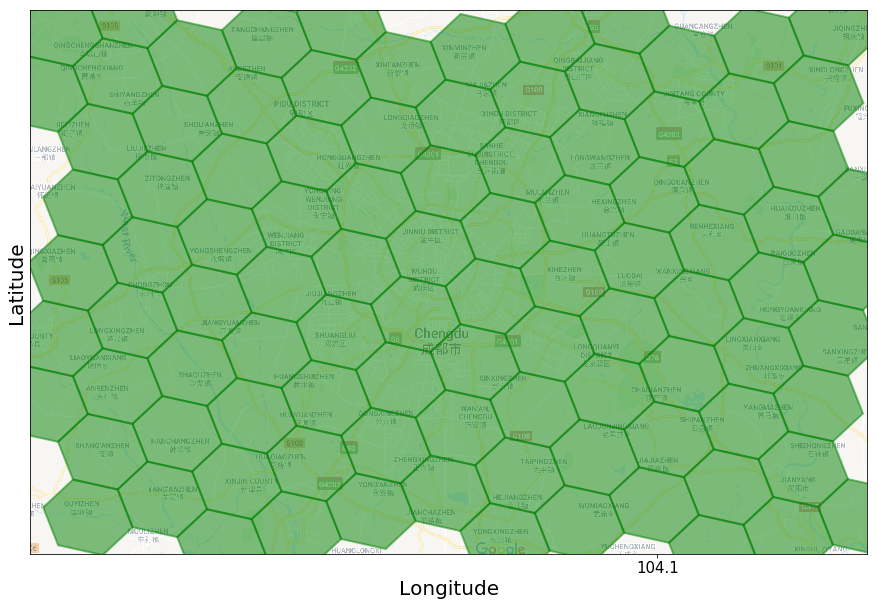

In [22]:
def draw_bkg(sw,ne):
    
    '''Initial parameter'''
    bg_path='Chengdu.png'
    
    '''Figure out'''
    img = plt.imread(bg_path)
    height, width = img.shape[:2]
    h1 = math.ceil(15./width*height)
    fig = plt.figure(figsize=(15,h1))
    ax = fig.add_subplot(111)
    xgrange, ygrange = ((sw[1], ne[1]), (sw[0], ne[0]))
    plt.xlim(xgrange)
    plt.ylim(ygrange)
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    plt.xticks(np.arange(xgrange[0], xgrange[1], 0.352/15))
    plt.yticks(np.arange(ygrange[0], ygrange[1], 0.2415/13))
    try:
        ax.imshow(img, extent=[x0, x1, y0, y1], aspect='auto', alpha=.5)
    except:
        pass
    return fig, ax, xgrange, ygrange



fig, ax, xgrange, ygrange=draw_bkg(southwest,northeast)

'''Axis'''

xmajorLocator   = MultipleLocator(0.1)
ymajorLocator   = MultipleLocator(0.1) 

ax.xaxis.set_major_locator(xmajorLocator)
ax.yaxis.set_major_locator(ymajorLocator)

for idx,row in Grid_range.iterrows():
    
    grid=row['grid']


    v_f,c_f=spatial_calculation.get_grid_shape(grid)


    pgon = plt.Polygon(([v_f[0].lng,v_f[0].lat], [v_f[1].lng,v_f[1].lat], [v_f[2].lng,v_f[2].lat]\
                            ,[v_f[3].lng,v_f[3].lat],[v_f[4].lng,v_f[4].lat],[v_f[5].lng,v_f[5].lat]),color='g',linewidth=2,fill=True,alpha=0.5)

    plt.gca().add_patch(pgon)


plt.tick_params(labelsize=15)

labels = ax.get_xticklabels() + ax.get_yticklabels()
font2 = {'weight': 'normal','size': 20}
plt.xlabel('Longitude', font2)
plt.ylabel('Latitude', font2)
plt.xlim((southwest[1], northeast[1]))
plt.ylim((southwest[0], northeast[0]))

plt.show()

In [23]:
All_grid=list(Grid_range['grid'])

'''State'''

State=list()
for grid in All_grid:
    for t_step in range(end_step):
        State.append(str(grid)+'-'+str(t_step))
        
State_range=pd.DataFrame(State,columns=['State'])

In [42]:
MODEL_PATH='Dataset/Order_data/'

Feature_table=pd.read_csv(os.path.join(MODEL_PATH, 'Feature_weekday.csv'))

Feature_table=Feature_table.drop(columns=['Unnamed: 0'])

Reward_dic={}

Capacity_dic={}

for idx,row in Feature_table.iterrows():
    Reward_dic[row['State']]=row['Reward_unit']
    Capacity_dic[row['State']]=row['Order_Cnt']
    


In [79]:
'''Action'''

Action_space={}

for grid in All_grid:
    
    for t_step in range(end_step):

        state=grid+'-'+str(t_step)
        
        
        Action_list=list()

        Action_candidate=['0'+'-'+grid]+['1'+'-'+g for g in spatial_calculation.grid_neighbor(grid, 0, 1)]+\
        ['2'+'-'+g for g in spatial_calculation.grid_neighbor(grid, 1, 2)]+\
        ['3'+'-'+g for g in spatial_calculation.grid_neighbor(grid, 2, 3)]+\
        ['4'+'-'+g for g in spatial_calculation.grid_neighbor(grid, 3, 4)]


        Action_=list()

        for a in Action_candidate:

            dest_step=t_step+int(a.split('-')[0])
            
            dest_grid=a.split('-')[1]
            
            dest_state=dest_grid+'-'+str(dest_step) 

            Action_.append(dest_state)

        Action_weight={}

        for i in range(len(Action_)):

            if Action_[i] in Reward_dic.keys():

                Action_weight[i]=Reward_dic[Action_[i]]

        layer=5

        while len(Action_weight)==0:

            Action_candidate=[str(layer)+'-'+g for g in spatial_calculation.grid_neighbor(grid, layer-1, layer)]

            Action_=list()

            for a in Action_candidate:

                dest_step=t_step+int(a.split('-')[0])

                dest_grid=a.split('-')[1]

                dest_state=dest_grid+'-'+str(dest_step) 

                Action_.append(dest_state)

            for i in range(len(Action_)):

                if Action_[i] in Reward_dic.keys():

                    Action_weight[i]=Reward_dic[Action_[i]]

            if layer>7:

                Action_weight[0]=1.0

                break

            layer+=1

        shortlist=sorted(Action_weight.items(),key=lambda item:item[1],reverse=True)[0:5]

        Action_list=[Action_candidate[idx[0]] for idx in shortlist]
        
        Action_filter=list()
        
        for a in Action_list:
            
            action_grid=a.split('-')[1]
            
            if action_grid in All_grid:
                
                Action_filter.append(a)
                
        if len(Action_filter)==0:
            
            Action_filter=['0'+'-'+grid]
            
        Action_space[state]=Action_filter   
        

hhh


14256

In [61]:
'''Macth probability'''

Match_PROB=Request_data.groupby(['Pickup_Gird','Pickup_step']).count()[['Order_ID']]

Match_PROB['Transition']=Match_PROB.index

Match_PROB['Pickup_Gird']=Match_PROB.apply(lambda x:x['Transition'][0],axis=1)

Match_PROB['Pickup_step']=Match_PROB.apply(lambda x:x['Transition'][1],axis=1)

Match_PROB=Match_PROB.reset_index(drop=True)

Match_PROB=Match_PROB.rename(index=str, columns={"Order_ID": "Order_Cnt"})

Match_PROB=Match_PROB[['Pickup_Gird','Pickup_step','Order_Cnt']]

Match_PROB['State']=Match_PROB.apply(lambda x:x['Pickup_Gird']+'-'+str(x['Pickup_step']),axis=1)

Match_PROB['Prob']=Match_PROB.apply(lambda x:round(x['Order_Cnt']/4.0,2) if x['Order_Cnt']<=4 else 1.00,axis=1)

Match_PROB=Match_PROB[['State','Prob']]

Match_PROB=State_range.merge(Match_PROB,on='State',how='left')

Match_PROB=Match_PROB.fillna(0.0)

Match_PROB_Dic={}

for idx,row in Match_PROB.iterrows():
    
    Match_PROB_Dic[row['State']]=row['Prob']
    
Match_PROB

,State,Prob
0,OL13F1i6602j1654-0,0.25
1,OL13F1i6602j1654-1,0.00
2,OL13F1i6602j1654-2,0.00
3,OL13F1i6602j1654-3,0.25
4,OL13F1i6602j1654-4,0.50
5,OL13F1i6602j1654-5,0.25
6,OL13F1i6602j1654-6,0.00
7,OL13F1i6602j1654-7,0.25
8,OL13F1i6602j1654-8,0.75
9,OL13F1i6602j1654-9,0.00


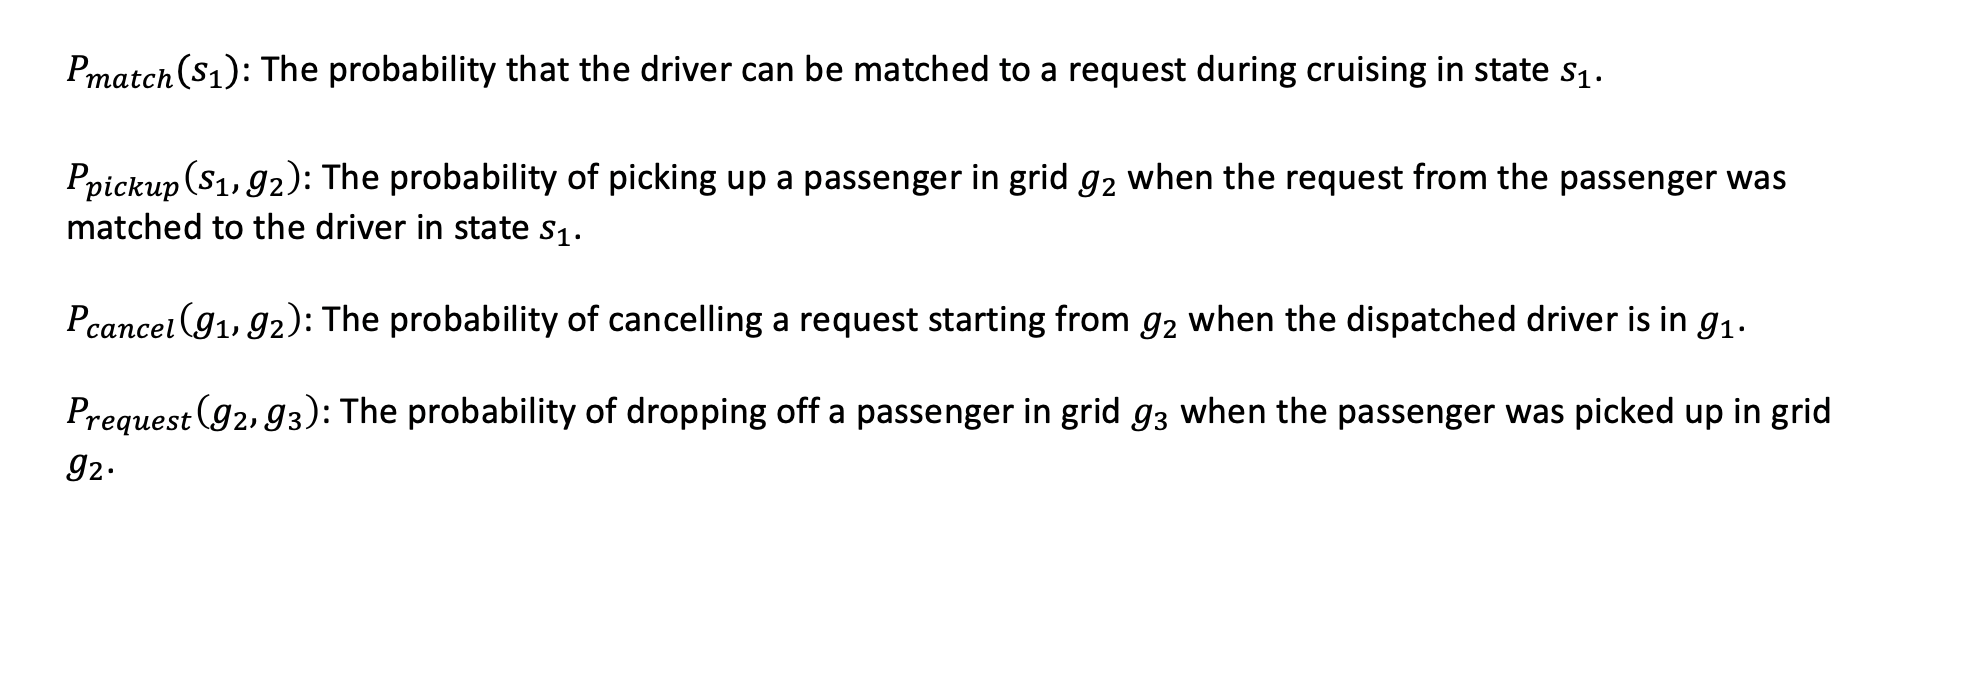

In [62]:

'''Trajectory merging'''

Dispatch_PROB=Tracectory_data.groupby(['Dispatch_Grid','Dispatch_step','Pickup_Gird']).count()[['Order_ID']]

Dispatch_PROB['Transition']=Dispatch_PROB.index

Dispatch_PROB['Dispatch_Grid']=Dispatch_PROB.apply(lambda x:x['Transition'][0],axis=1)

Dispatch_PROB['Dispatch_step']=Dispatch_PROB.apply(lambda x:x['Transition'][1],axis=1)

Dispatch_PROB['Pickup_Gird']=Dispatch_PROB.apply(lambda x:x['Transition'][2],axis=1)

Dispatch_PROB=Dispatch_PROB.reset_index(drop=True)

Dispatch_PROB=Dispatch_PROB.rename(index=str, columns={"Order_ID": "Order_Cnt"})

Dispatch_PROB=Dispatch_PROB[['Dispatch_Grid','Dispatch_step','Pickup_Gird','Order_Cnt']]


'''Temp'''

TEMP=Tracectory_data.groupby(['Dispatch_Grid','Dispatch_step']).count()[['Order_ID']]

TEMP['Transition']=TEMP.index

TEMP['Dispatch_Grid']=TEMP.apply(lambda x:x['Transition'][0],axis=1)

TEMP['Dispatch_step']=TEMP.apply(lambda x:x['Transition'][1],axis=1)

TEMP=TEMP.reset_index(drop=True)

TEMP=TEMP.rename(index=str, columns={"Order_ID": "Order_Sum"})

TEMP=TEMP[['Dispatch_Grid','Dispatch_step','Order_Sum']]

Dispatch_PROB=Dispatch_PROB.merge(TEMP,on=['Dispatch_Grid','Dispatch_step'])

Dispatch_PROB['Prob']=Dispatch_PROB.apply(lambda x:round(float(x['Order_Cnt']/x['Order_Sum']),2),axis=1)

Dispatch_PROB=Dispatch_PROB[['Dispatch_Grid','Dispatch_step','Pickup_Gird','Prob']]

Dispatch_PROB['Pickup_step']=Dispatch_PROB.apply(lambda x:x['Dispatch_step']+1,axis=1)

Dispatch_PROB['Dispatch_state']=Dispatch_PROB.apply(lambda x:x['Dispatch_Grid']+'-'+str(x['Dispatch_step']),axis=1)

Dispatch_PROB['Pickup_state']=Dispatch_PROB.apply(lambda x:x['Pickup_Gird']+'-'+str(x['Pickup_step']),axis=1)

Dispatch_PROB=Dispatch_PROB[['Dispatch_state','Pickup_state','Prob']]

Dispatch_PROB_Dic={}

for idx,row in Dispatch_PROB.iterrows():
    
    if row['Dispatch_state'] not in Dispatch_PROB_Dic.keys():
    
        Dispatch_PROB_Dic[row['Dispatch_state']]={}
        
        Dispatch_PROB_Dic[row['Dispatch_state']][row['Pickup_state']]=row['Prob']
        
    else:
        
        Dispatch_PROB_Dic[row['Dispatch_state']][row['Pickup_state']]=row['Prob']
        

            

In [63]:
'''Request Distribution'''

Request_PROB=Request_data.groupby(['Pickup_Gird','Pickup_step','Dropoff_Gird']).count()[['Order_ID']]

Request_PROB['Transition']=Request_PROB.index

Request_PROB['Pickup_Gird']=Request_PROB.apply(lambda x:x['Transition'][0],axis=1)

Request_PROB['Pickup_step']=Request_PROB.apply(lambda x:x['Transition'][1],axis=1)

Request_PROB['Dropoff_Gird']=Request_PROB.apply(lambda x:x['Transition'][2],axis=1)

Request_PROB=Request_PROB.reset_index(drop=True)

Request_PROB=Request_PROB.rename(index=str, columns={"Order_ID": "Order_Cnt"})

Request_PROB=Request_PROB[['Pickup_Gird','Pickup_step','Dropoff_Gird','Order_Cnt']]


TEMP=Request_data.groupby(['Pickup_Gird','Pickup_step']).count()[['Order_ID']]

TEMP['Transition']=TEMP.index

TEMP['Pickup_Gird']=TEMP.apply(lambda x:x['Transition'][0],axis=1)

TEMP['Pickup_step']=TEMP.apply(lambda x:x['Transition'][1],axis=1)

Request_PROB=Request_PROB.reset_index(drop=True)

TEMP=TEMP.rename(index=str, columns={"Order_ID": "Order_Sum"})

TEMP=TEMP.reset_index(drop=True)

TEMP=TEMP[['Pickup_Gird','Pickup_step','Order_Sum']]

Request_PROB=Request_PROB.merge(TEMP,on=['Pickup_Gird','Pickup_step'])

Request_PROB['Prob']=Request_PROB.apply(lambda x:round(float(x['Order_Cnt']/x['Order_Sum']),2),axis=1)

Request_PROB=Request_PROB[['Pickup_Gird','Pickup_step','Dropoff_Gird','Prob']]

Request_PROB['Dropoff_step']=Request_PROB.apply(lambda x:int(x['Pickup_step'])+math.ceil(spatial_calculation.get_grid_dis(x['Pickup_Gird'],x['Dropoff_Gird'])/3),axis=1)

Request_PROB['Pickup_state']=Request_PROB.apply(lambda x:x['Pickup_Gird']+'-'+str(x['Pickup_step']),axis=1)

Request_PROB['Dropoff_state']=Request_PROB.apply(lambda x:x['Dropoff_Gird']+'-'+str(x['Dropoff_step']),axis=1)

Request_PROB=Request_PROB[['Pickup_state','Dropoff_state','Prob']]

Request_PROB=Request_PROB.merge(State_range,left_on='Pickup_state',right_on='State')

Request_PROB=Request_PROB[['Pickup_state','Dropoff_state','Prob']]

Request_PROB=Request_PROB.merge(State_range,left_on='Dropoff_state',right_on='State')

Request_PROB=Request_PROB[['Pickup_state','Dropoff_state','Prob']]

Request_PROB

Request_PROB_Dic={}

for idx,row in Request_PROB.iterrows():
    
    if row['Pickup_state'] not in Request_PROB_Dic.keys():
    
        Request_PROB_Dic[row['Pickup_state']]={}
        
        Request_PROB_Dic[row['Pickup_state']][row['Dropoff_state']]=row['Prob']
        
    else:
        
        Request_PROB_Dic[row['Pickup_state']][row['Dropoff_state']]=row['Prob']
        



In [64]:
'''Gain data'''

Gain_table=Request_data.groupby(['Pickup_Gird','Pickup_step']).mean()[['Reward_unit']]

Gain_table['Transition']=Gain_table.index

Gain_table['Pickup_Gird']=Gain_table.apply(lambda x:x['Transition'][0],axis=1)

Gain_table['Pickup_step']=Gain_table.apply(lambda x:x['Transition'][1],axis=1)

Gain_table=Gain_table.reset_index(drop=True)

Gain_table=Gain_table[['Pickup_Gird','Pickup_step','Reward_unit']]

Gain_table['Pickup_state']=Gain_table.apply(lambda x:x['Pickup_Gird']+'-'+str(x['Pickup_step']),axis=1)

Gain_table=Gain_table[['Pickup_state','Reward_unit']]

Gain_table=State_range.merge(Gain_table,left_on='State',right_on='Pickup_state',how='left')

Gain_table=Gain_table[['State','Reward_unit']]

Gain_table=Gain_table.fillna(0.0)

Gain_table_Dic={}

for idx,row in Gain_table.iterrows():
    
    Gain_table_Dic[row['State']]=row['Reward_unit']



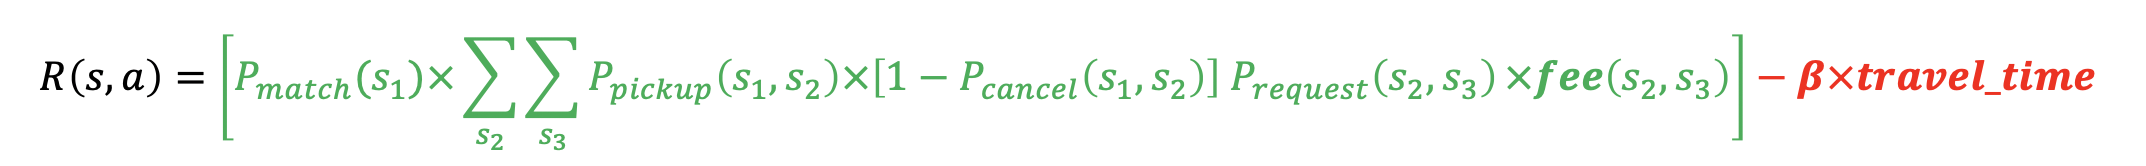

In [80]:
'''Reward'''

beta=1

Reward={}

for state in State:
    
    Reward[state]={}
    
    current_grid=state.split('-')[0];
    
    current_stamp=int(state.split('-')[1])

    for action in Action_space[state]:

        next_grid=action.split('-')[1]
        
        travel=int(action.split('-')[0])
        
        next_stamp=int(current_stamp)+travel      
        
        next_state=str(next_grid)+'-'+str(next_stamp)

        if next_stamp<end_step:

            '''基于预估旅行时间的空驶成本'''

            cruise_cost=beta*1

            '''S1的匹配概率'''
            
            Prob=Match_PROB_Dic[next_state]
            
            gain=0
            
            '''在S2接单的概率'''
            
            if next_state in Dispatch_PROB_Dic.keys():
                
                for pickup_state,pickup_prob in Dispatch_PROB_Dic[next_state].items():
                    
                    pickup_stamp=int(pickup_state.split('-')[1])
                    
                    if pickup_stamp<end_step:
                        
                        pickup_award=Gain_table_Dic[pickup_state]

                        gain+=pickup_prob*pickup_award
        
            pickup_order=Prob*gain

            Reward[state][action]=round(pickup_order-cruise_cost,2)
            

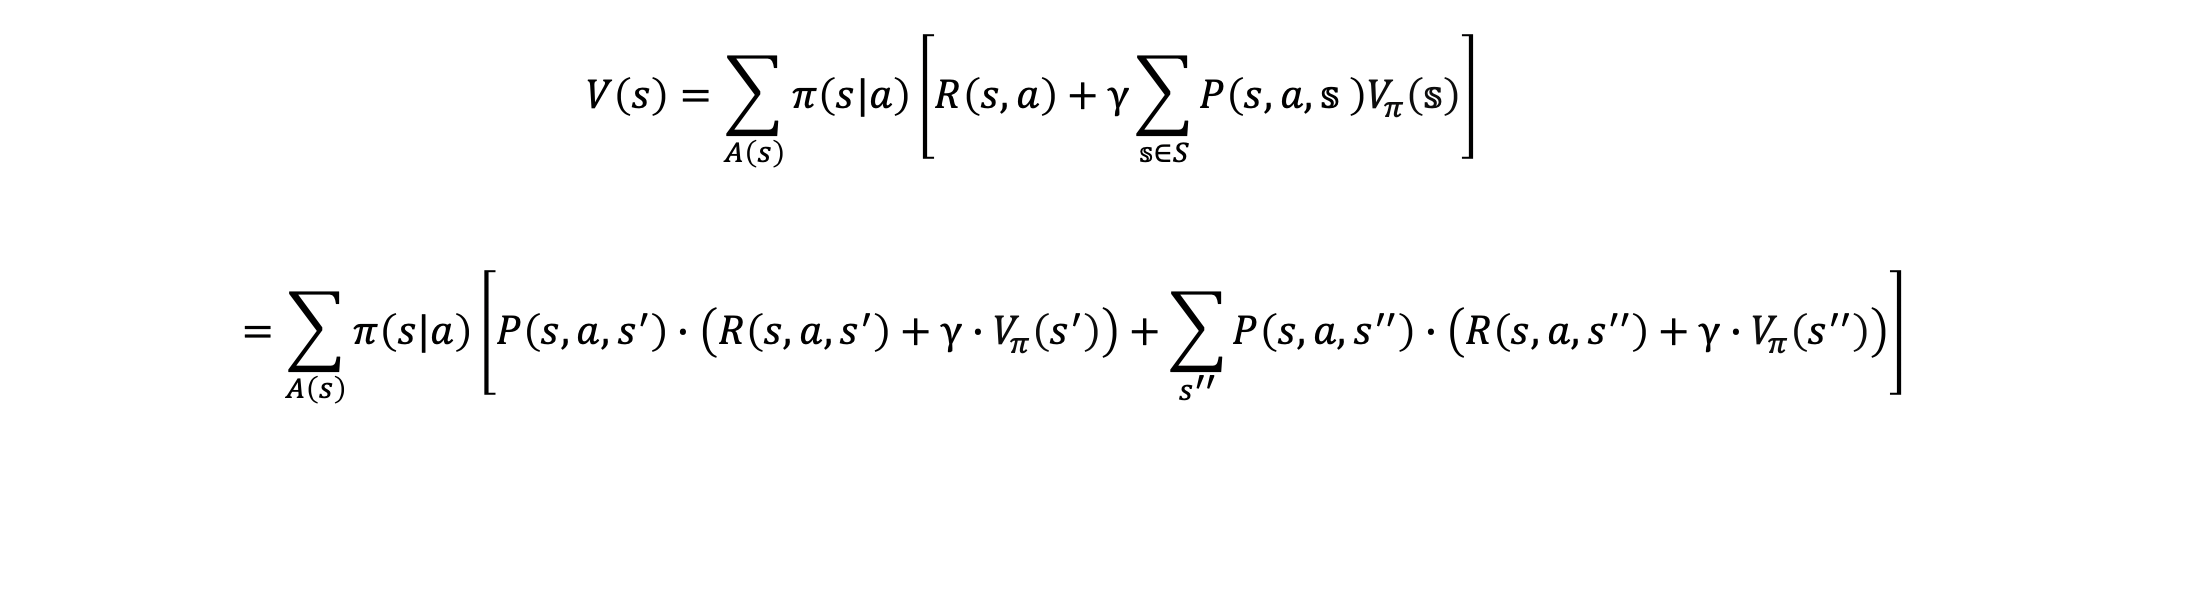

In [81]:
def Bellman(state,A_set,State_value,Match_PROB_Dic,Dispatch_PROB_Dic,Request_PROB_Dic,Reward,gumma):
    
    '''获取当前位置和时间步'''
    current_grid=state.split('-')[0]
    current_stamp=int(state.split('-')[1])
    
    '''贝尔曼方程迭代'''
    
    Action_prob=round(float(1)/len(A_set[state]),3)
    
    V=0
    
    for action in A_set[state]:
        
        next_grid=action.split('-')[1]
        travel_time=int(action.split('-')[0])
        next_stamp=int(current_stamp+travel_time)
        next_state=next_grid+'-'+str(next_stamp)
        
        if next_stamp>=end_step:
            
            continue
        
        '''定义当前的reward'''
        
        R=Action_prob*Reward[state][action]
        
        '''若司机未能接到单'''
        
        match_prob=Match_PROB_Dic[next_state]
        
        V_=(1-Prob)*State_value[next_state]
        
        '''若司机可以接到单'''
        
        if next_state in Dispatch_PROB_Dic.keys():
            
            for pickup_state,pickup_prob in Dispatch_PROB_Dic[next_state].items():
                    
                    if pickup_state in Request_PROB_Dic.keys():
                        
                        for dest_state,request_prob in Dispatch_PROB_Dic[next_state].items():
                            
                            dest_time=int(dest_state.split('-')[1])
                            
                            if dest_time<end_step:
                        
                                V_+=match_prob*pickup_prob*request_prob*State_value[dest_state]
                            
        V+= R+ Action_prob*gumma*V_                 
        
    return V

'''基于Greedy的动作选择'''

def Update_action(State_value,A_set):
    
    '''Greedy筛选动作'''
    
    for state,action_list in A_set.items():
        
        Next_value={}
        
        current_grid=state.split('-')[0]
        
        current_stamp=int(state.split('-')[1])
        
        for action in action_list:
            
            next_grid=action.split('-')[1]
            
            travel_time=int(action.split('-')[0])
            
            next_stamp=int(current_stamp+travel_time)
            
            next_state=next_grid+'-'+str(next_stamp)
            
            if next_stamp>=end_step:
            
                continue
            
            Next_value[action]=State_value[next_state]
            
        if len(Next_value)!=0:
        
            Max_value=max(Next_value.values())

            for action,action_value in Next_value.items():

                if action_value<Max_value:

                    A_set[state].remove(action)
                
    return A_set

In [82]:
'''定义初始状态，所有状态价值为0'''

State_value={state:0 for state in State}
diff=0
Value_record={}
Origin_policy=copy.deepcopy(Action_space)
pre_V_sum=0
iteration=100
gumma=0.8

for i in range(iteration):

    for state in State:

        State_value[state]=Bellman(state,Origin_policy,State_value,Match_PROB_Dic,Dispatch_PROB_Dic,Request_PROB_Dic,Reward,gumma)

    Value_record[i]=sum(State_value.values())

    Origin_policy=Update_action(State_value,Origin_policy)

    diff=abs(Value_record[i]-pre_V_sum)

    if diff<5:

        break

    pre_V_sum=Value_record[i]

Optimal_policy=Origin_policy



In [83]:
Value_statistic=pd.DataFrame(Value_record.keys(),columns=['iteration'])
Value_statistic['V_sum']=Value_record.values()
Value_statistic

State_value_table=pd.DataFrame(State_value.keys(),columns=['State'])
State_value_table['value']=State_value.values()
State_value_table


,State,value
0,OL13F1i6602j1654-0,-1.000000
1,OL13F1i6602j1654-1,-1.000000
2,OL13F1i6602j1654-2,4.385920
3,OL13F1i6602j1654-3,3.490497
4,OL13F1i6602j1654-4,1.182805
5,OL13F1i6602j1654-5,-1.000000
6,OL13F1i6602j1654-6,-1.000000
7,OL13F1i6602j1654-7,2.980842
8,OL13F1i6602j1654-8,1.110000
9,OL13F1i6602j1654-9,0.788467


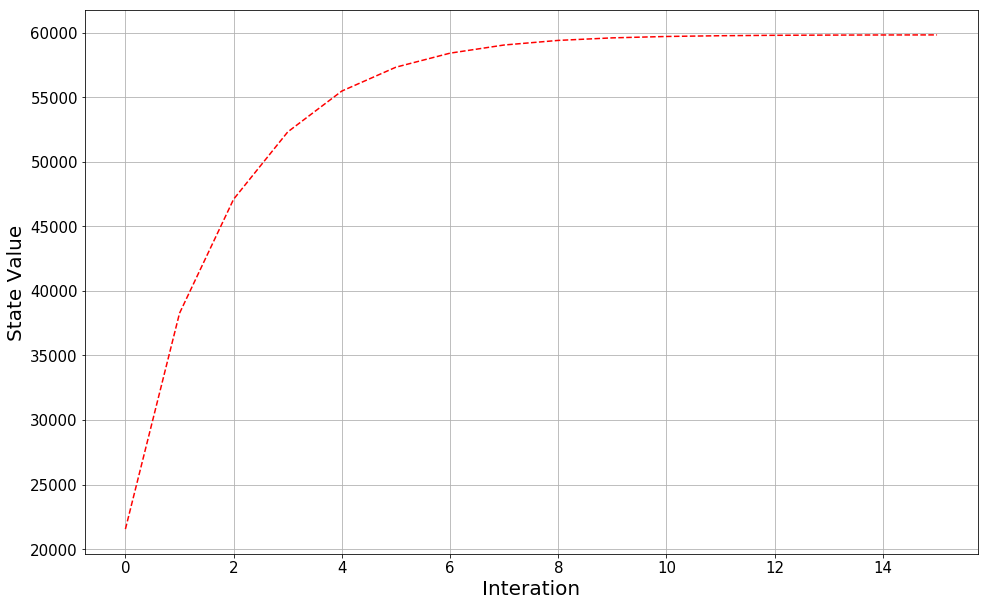

In [84]:
figsize = 16,10
figure,ax = plt.subplots(figsize=figsize)
plt.tick_params(labelsize=15)
labels = ax.get_xticklabels() + ax.get_yticklabels()
font = {'weight' : 'normal','size': 20}

plt.plot(Value_record.keys(),Value_record.values(),'r--')
plt.xlabel('Interation',font)
plt.ylabel('State Value',font)
plt.grid()
plt.show()